In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np

## Create our custom datset object

In [ ]:
class MassachusettsRoadsDataset(Dataset):
    """
    Massachusetts Roads Dataset
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(((".png")))])
    
    def __len__(self):
        return len(self.images)     
    
    def __getitem__(self, idx: int):
        #Load image and mask
        img_path = os.path.join(self.image_dir, self.images[idx])
        #Labels in the Massachusets
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        #Get the label in grayscale
        mask = Image.open(mask_path).convert("L")
        #Convert image and mask to array in case augmentation using albumentations
        image = np.array(image)
        mask = np.array(mask)
        #Binraize the mask into 0,1
        mask = (mask > 128).astype(np.uint8)

        #Apply transform with Albumentation (remember Albumentations needs np.arrays!)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            #mask = augmented['mask']
            mask = torch.tensor(augmented['mask'], dtype=torch.long)
        else:
            #Conver to tensor
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)/255
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask, self.images[idx]
 


## Create dataloaders

In [ ]:
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

bs = 8 #batch size

tr_img_dir = "dataset_road_kaggle/training/images"
tr_mask_dir = "dataset_road_kaggle/training/groundtruth"
val_img_dir = "dataset_road_kaggle/val/images"
val_mask_dir = "dataset_road_kaggle/val/gt"


#Transformations
transform = A.Compose([
    A.Resize(416, 416),
    A.HorizontalFlip(p=0.5),  # Horizontal Flip
    A.RandomBrightnessContrast(p=0.3),  # Adjust brightness/contrast
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.4),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.4), #Shift, scale and rotate an image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImgNet normalization values
    ToTensorV2()  # Conver to tensor
])


#Create datasets
tr_ds = MassachusettsRoadsDataset(tr_img_dir, tr_mask_dir, transform)
val_ds = MassachusettsRoadsDataset(val_img_dir, val_mask_dir, transform)

#Create dataloaders (random split)
tr_dl = DataLoader(tr_ds, bs, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, bs, shuffle=True, num_workers=4)


## Data visualization

In [ ]:
from src.visualization import *

### Visualize images from the dataset (not augmented)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831371].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216992].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5354247].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


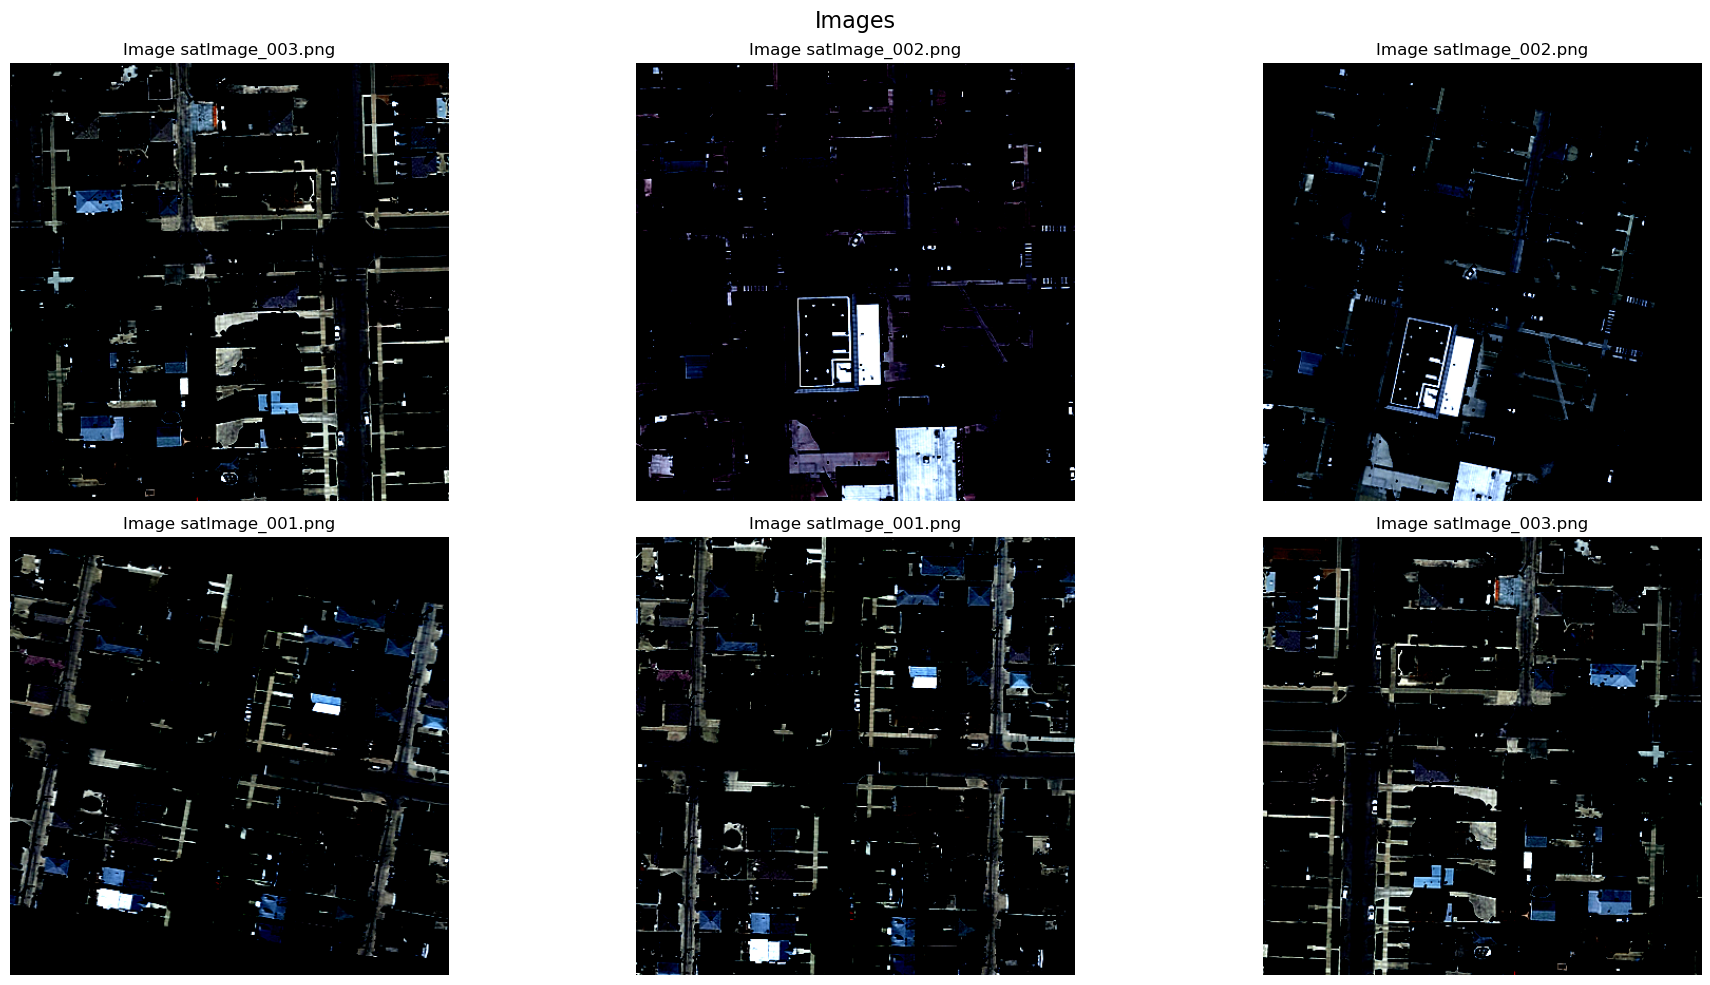

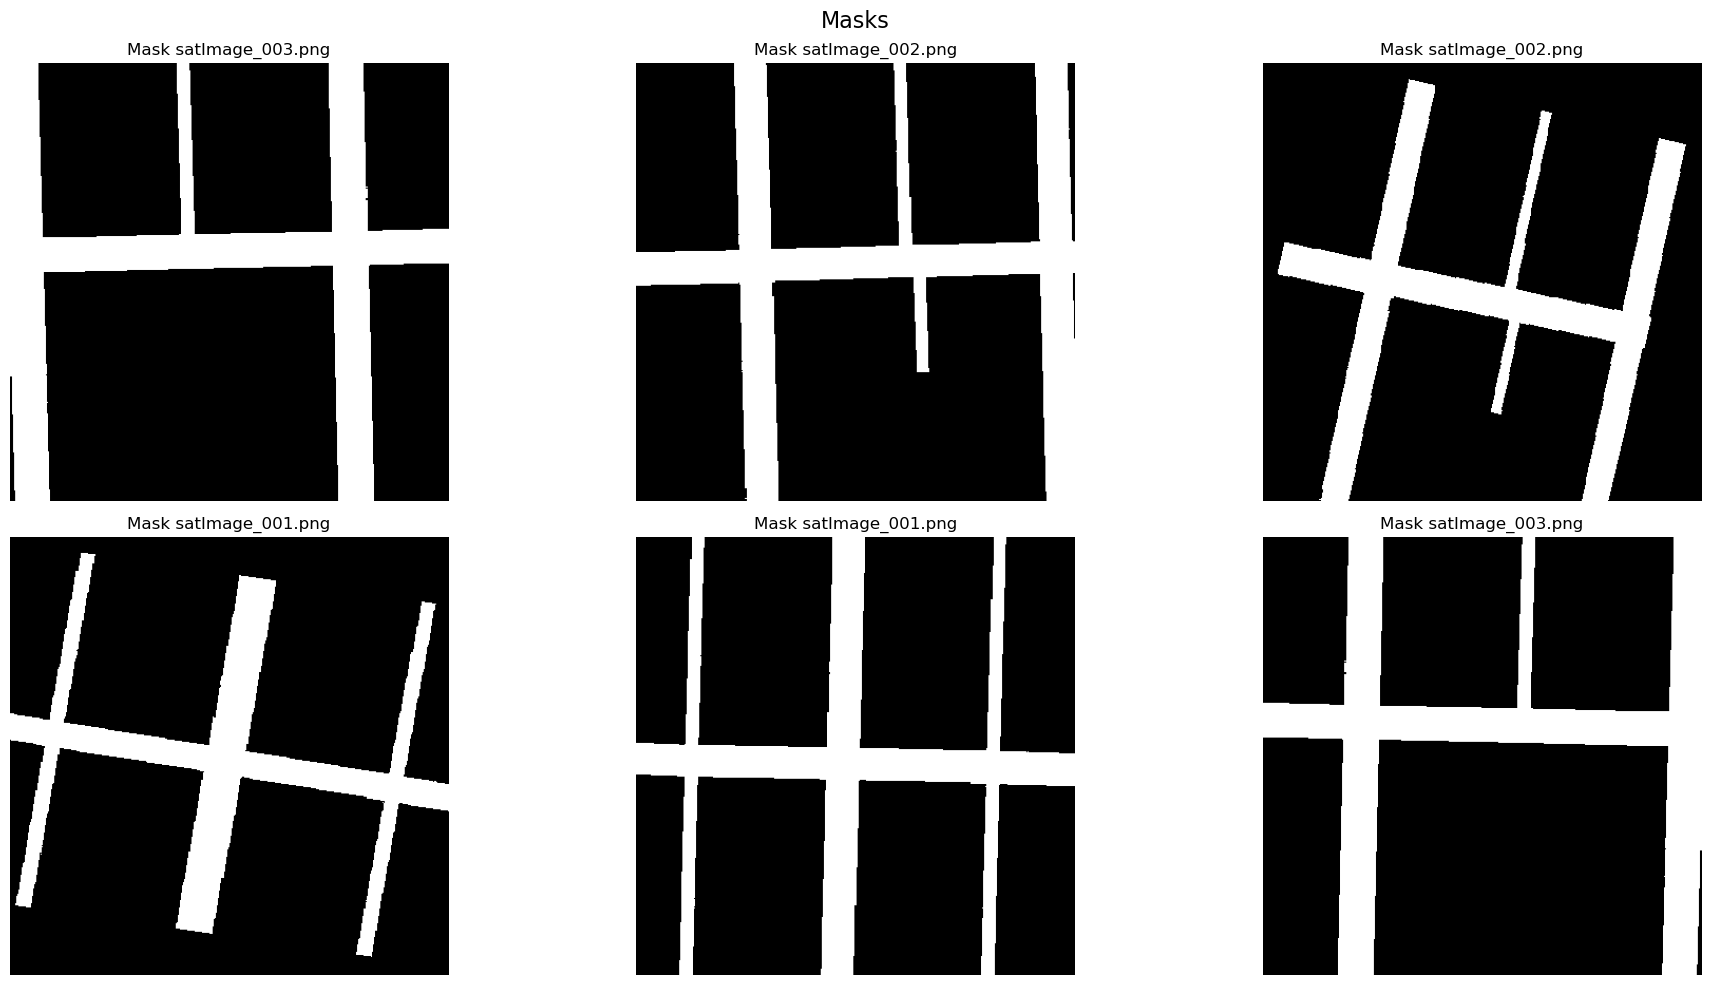

In [ ]:
#The function as it is does not discriminate between normalized and unormalized images, so make sure the images are not normalized.
#Below is the same function with the param: is_batch=True, which assumes is a transformed batch.
visualize_data(data=val_ds, n_imgs=6, rows=2) #Test not transformed, that's why we viz that


### Visualize images from the dataloaders (with augmentations)

/tmp/ipykernel_1121/65586287.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_1121/65586287.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_1121/65586287.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_1121/65586287.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

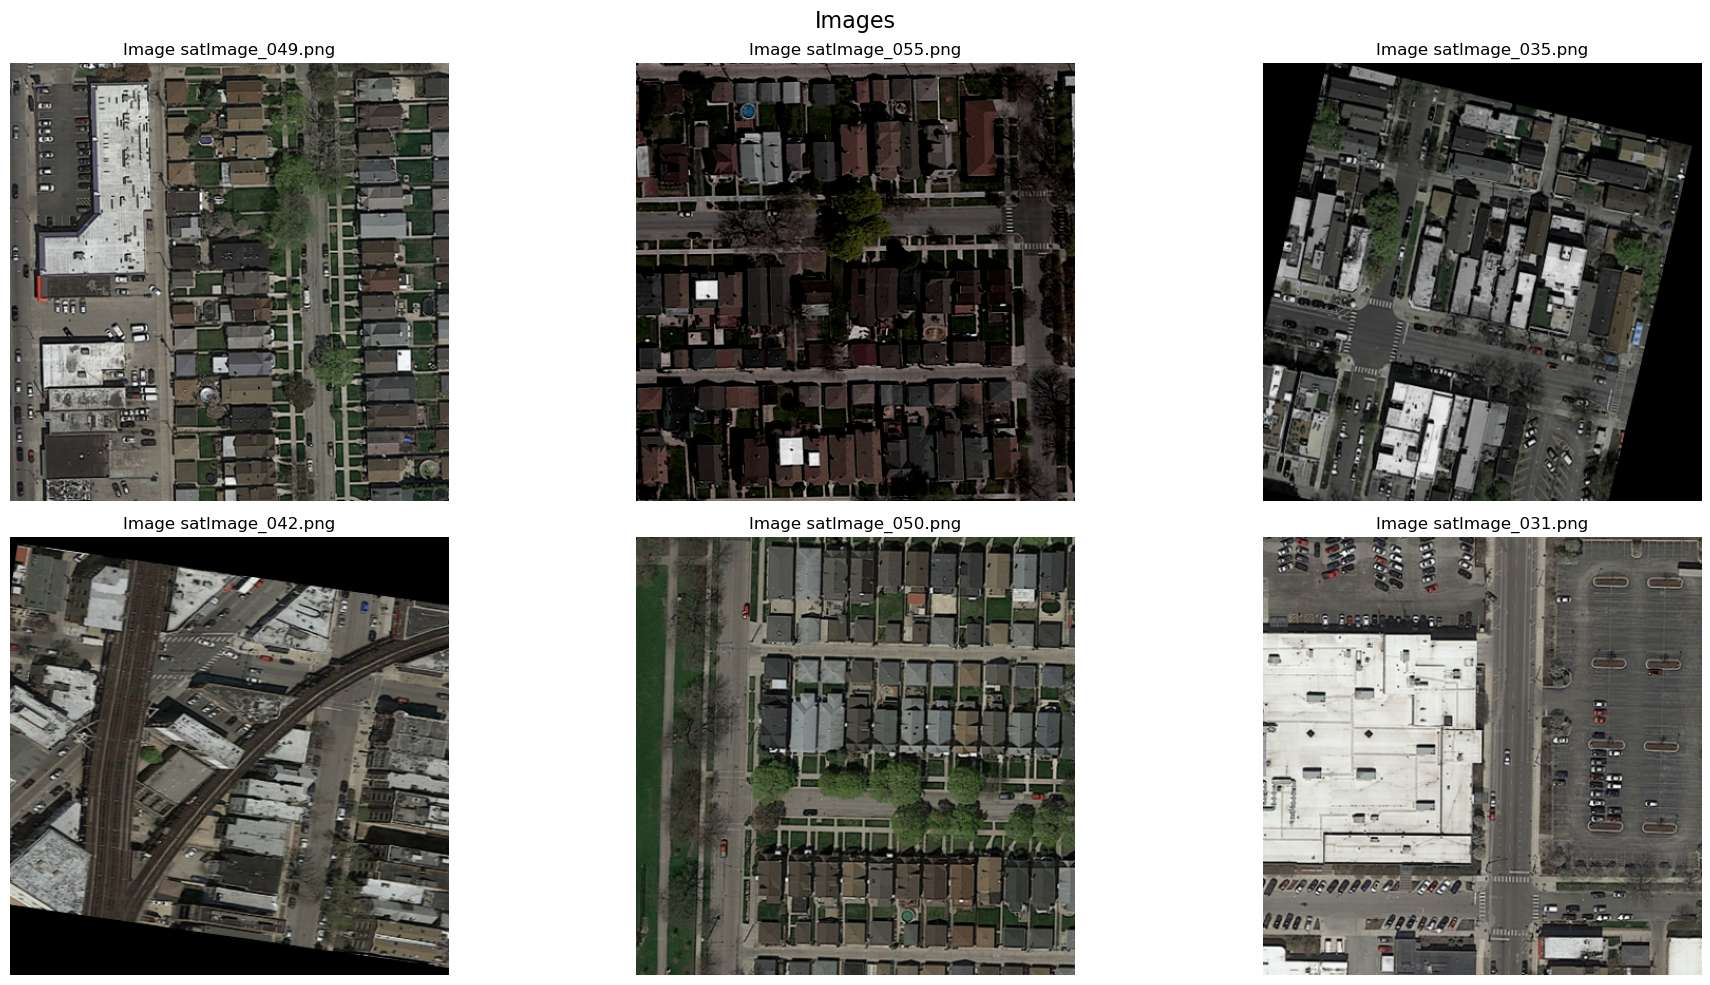

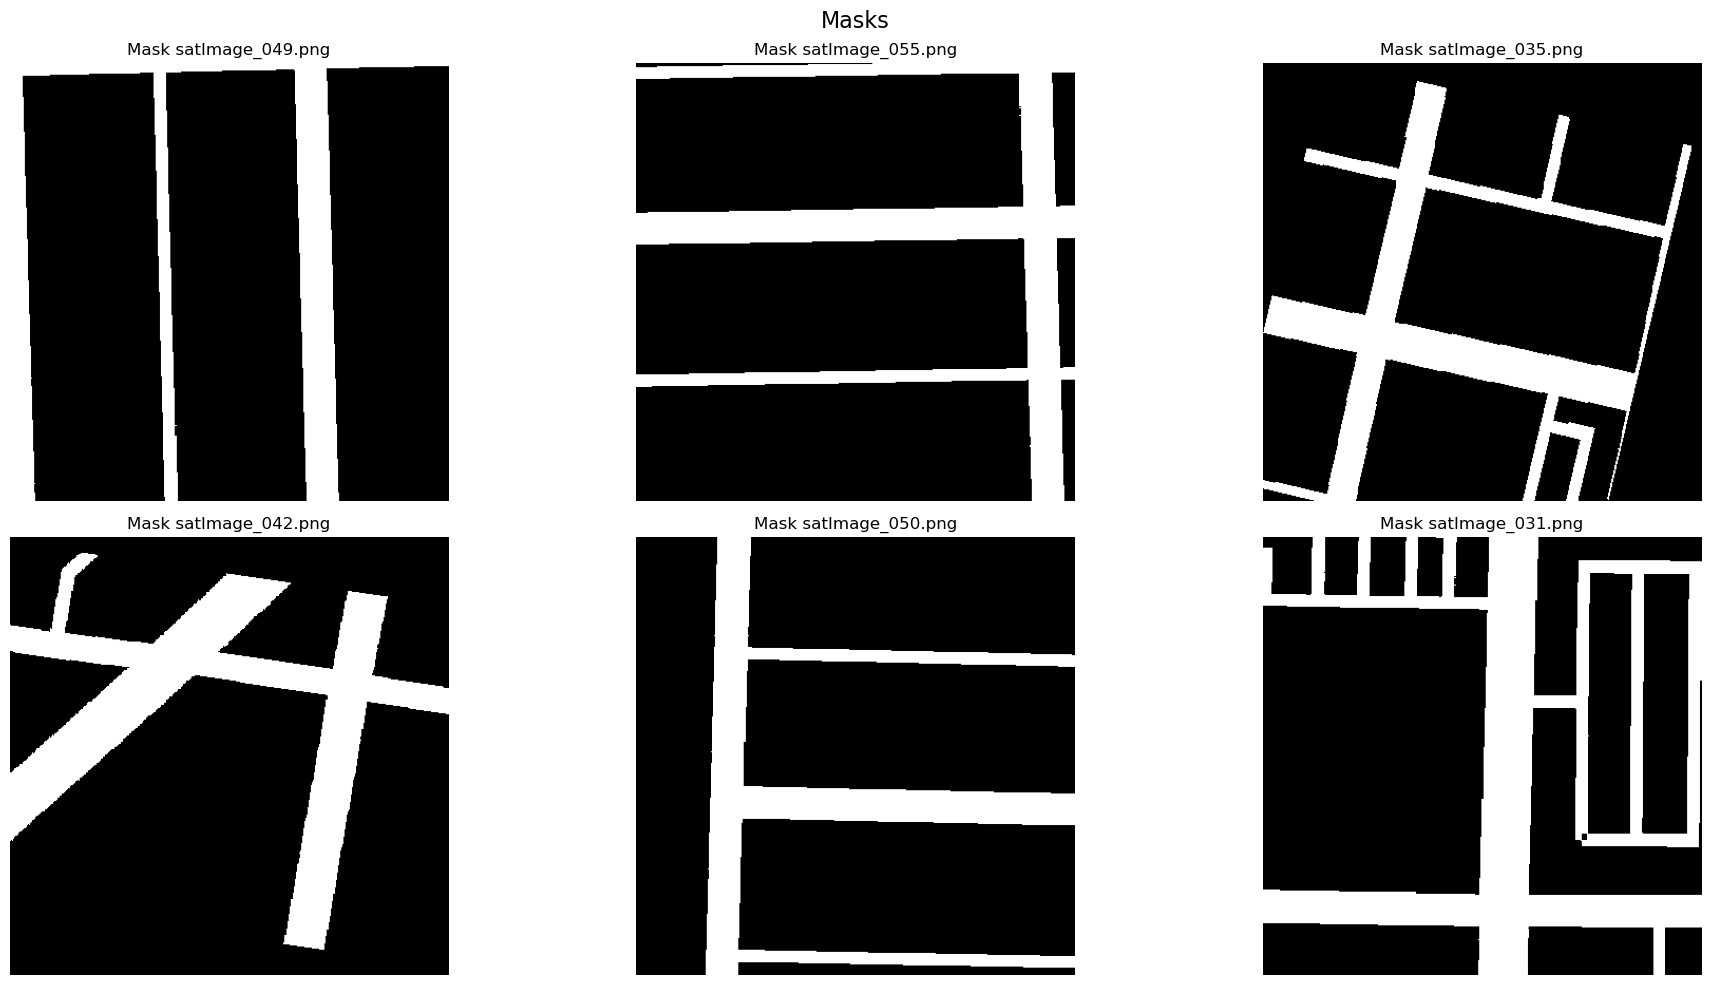

In [11]:
visualize_data(tr_dl, 6, 2,is_batch=True) #is_batch=True is for dataloaders with aug

In [12]:
#Code to avoid some errors that are just informative
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Model definition and training

In [ ]:
import segmentation_models_pytorch as smp
from src.training_seg import *
from torch.amp import GradScaler


#Definition of all the hyperparameters and other info to track manually
hyperparams = {
    "experiment_name": "Road Segmentation - Kaggle",
    "run_id": "17_400_noAug",
    "lr": 1e-4,
    "bs": bs,  # Defined when creating the dataloaders
    "epochs": 50,
    "loss_fn": "combined",
    "optimizer": "Adam",
    "scheduler": "StepLR",
    "precision FP16": True,
    "model_type": "Unet",
    "encoder_name": "efficientnet-b0", 
    "num_classes": 1,
    "patience": 5
}
#Initialize a variable to track validation loss (used for saving best model)
#best_val_loss = float("inf")
best_val_miou = 0
counter = 0 # Counte for early stop
#Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
#Define the model
model = smp.Unet(
    encoder_name=hyperparams["encoder_name"],  
    encoder_weights="imagenet",                # Uso de pesos pre-entrenados en ImageNet
    in_channels=3,                             # Número de canales de entrada (RGB)
    classes=hyperparams["num_classes"],        # Número de clases de salida   
)

#Initialize MLflow experiment
mlflow.set_experiment(hyperparams["experiment_name"])

#Initialize run for logging
run = mlflow.start_run(run_name=f"{hyperparams['experiment_name']}_{hyperparams['run_id']}")
run_id = run.info.run_id
print(f"Run ID: {run_id}")
#Log hyperparams
for key, value in hyperparams.items():
    mlflow.log_param(key, str(value))


#Initialize setup for our transfer learning
model, epochs, device,  loss_fn, optimizer, scheduler = setup_train(model, device, hyperparams)
#Create GradScaler for FP16 mixup calcs
scaler = GradScaler()

for epoch in range(epochs):
    #Train Step
    train_metrics = train_one_epoch(model, hyperparams["num_classes"], tr_dl, device, loss_fn, optimizer, scaler, epoch)
    #Val step
    val_metrics = val_one_epoch(model, hyperparams["num_classes"], val_dl, device, loss_fn, epoch)
    #Print metrics
    print(f"Epoch {epoch + 1}: {train_metrics} | {val_metrics}")
    # Update the learning rate using the scheduler
    scheduler.step()  # Reduces LR
    current_lr = scheduler.get_last_lr()[0]  # Obtain current LR for logging
    mlflow.log_metric("learning_rate", current_lr, step=epoch) #Log the LR

    #Early stop check and saving checkpoint if val loss is better
    if val_metrics["val_miou"] > best_val_miou:
        best_val_miou = val_metrics["val_miou"]  #Update best val
        counter = 0  #Reset to 0
        model_path = f"saved_models/best_model_{hyperparams['experiment_name']}_run_{run_id}.pth"
        #Save the model
        os.makedirs("saved_models", exist_ok=True)
        torch.save(model.state_dict(), model_path)
        #Log the model as a MLflow artifact
        mlflow.log_artifact(model_path)
        print(f"Epoch {epoch + 1}: Validation mIoU improved to {best_val_miou:.4f}, saving model...")
    else:
        counter += 1  # Counter goes up
        print(f"Epoch {epoch + 1}: No improvement in validation mIoU. Counter: {counter}/{hyperparams['patience']}")
    
    # Check early stopping condition
    if counter >= hyperparams["patience"]:
        print(f"Stopping early at epoch {epoch + 1}. Best validation loss: {best_val_miou:.4f}")
        break  # Exit training

#During our training, we are creating a summarywriter object for tensorboad. Once train is finished, close it.    
#Good practice is to clear memory
mlflow.end_run()
del optimizer
del loss_fn
del scaler
torch.cuda.empty_cache()


Run ID: 006e4c4278b64252a01f1e914fcdf79c


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch 1: {'train_loss': 0.8372910817464193, 'train_miou': 0.2038533025317722, 'train_dice': 0.33278864953253007, 'train_PA': 0.46943603290451896} | {'val_loss': 0.796068012714386, 'val_miou': 0.2099962681531906, 'val_dice': 0.34660279750823975, 'val_PA': 0.47610196471214294}
Epoch 1: Validation mIoU improved to 0.2100, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch 2: {'train_loss': 0.8034198350376553, 'train_miou': 0.22970658706294167, 'train_dice': 0.36618239018652177, 'train_PA': 0.5039285918076833} | {'val_loss': 0.7779462337493896, 'val_miou': 0.24450235068798065, 'val_dice': 0.3921702802181244, 'val_PA': 0.4477527439594269}
Epoch 2: Validation mIoU improved to 0.2445, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch 3: {'train_loss': 0.7780558202001784, 'train_miou': 0.24942723578876919, 'train_dice': 0.3911557032002343, 'train_PA': 0.536539614200592} | {'val_loss': 0.7581705451011658, 'val_miou': 0.26397815346717834, 'val_dice': 0.41686946153640747, 'val_PA': 0.4564262330532074}
Epoch 3: Validation mIoU improved to 0.2640, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 4: {'train_loss': 0.7518719368510776, 'train_miou': 0.27436061865753597, 'train_dice': 0.4216623273160722, 'train_PA': 0.580609937508901} | {'val_loss': 0.7337112426757812, 'val_miou': 0.2843109369277954, 'val_dice': 0.4417763650417328, 'val_PA': 0.4768803119659424}
Epoch 4: Validation mIoU improved to 0.2843, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch 5: {'train_loss': 0.7166265447934469, 'train_miou': 0.30690132743782467, 'train_dice': 0.4601113200187683, 'train_PA': 0.6336548659536574} | {'val_loss': 0.7095959186553955, 'val_miou': 0.2980106770992279, 'val_dice': 0.4585804045200348, 'val_PA': 0.49131321907043457}
Epoch 5: Validation mIoU improved to 0.2980, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch 6: {'train_loss': 0.6676985820134481, 'train_miou': 0.35455355048179626, 'train_dice': 0.5141468246777853, 'train_PA': 0.7010362082057529} | {'val_loss': 0.675105631351471, 'val_miou': 0.33007335662841797, 'val_dice': 0.4956059455871582, 'val_PA': 0.5568209290504456}
Epoch 6: Validation mIoU improved to 0.3301, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 7: {'train_loss': 0.6152524285846286, 'train_miou': 0.4286046392387814, 'train_dice': 0.5893201960457696, 'train_PA': 0.7754355072975159} | {'val_loss': 0.6384186148643494, 'val_miou': 0.3776102662086487, 'val_dice': 0.5473008155822754, 'val_PA': 0.6409202814102173}
Epoch 7: Validation mIoU improved to 0.3776, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch 8: {'train_loss': 0.566706551445855, 'train_miou': 0.5130389498339759, 'train_dice': 0.6687339676751031, 'train_PA': 0.8397535483042399} | {'val_loss': 0.5947906970977783, 'val_miou': 0.46618956327438354, 'val_dice': 0.6347771883010864, 'val_PA': 0.7533370852470398}
Epoch 8: Validation mIoU improved to 0.4662, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch 9: {'train_loss': 0.5283605125215318, 'train_miou': 0.5776215460565355, 'train_dice': 0.7230684227413602, 'train_PA': 0.8788064122200012} | {'val_loss': 0.5373725295066833, 'val_miou': 0.5954335927963257, 'val_dice': 0.7458343505859375, 'val_PA': 0.857161283493042}
Epoch 9: Validation mIoU improved to 0.5954, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch 10: {'train_loss': 0.4957840045293172, 'train_miou': 0.6343385312292311, 'train_dice': 0.7671602699491713, 'train_PA': 0.9037582609388564} | {'val_loss': 0.5020531415939331, 'val_miou': 0.6605371832847595, 'val_dice': 0.794266402721405, 'val_PA': 0.892421543598175}
Epoch 10: Validation mIoU improved to 0.6605, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 11: {'train_loss': 0.4725378354390462, 'train_miou': 0.6631598737504747, 'train_dice': 0.7892574999067519, 'train_PA': 0.9155540466308594} | {'val_loss': 0.467485249042511, 'val_miou': 0.7073197364807129, 'val_dice': 0.8276084065437317, 'val_PA': 0.9139677286148071}
Epoch 11: Validation mIoU improved to 0.7073, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 12: {'train_loss': 0.4483378032843272, 'train_miou': 0.6925612290700277, 'train_dice': 0.8107983072598776, 'train_PA': 0.9266713261604309} | {'val_loss': 0.43939146399497986, 'val_miou': 0.7298499941825867, 'val_dice': 0.8430787920951843, 'val_PA': 0.9220905303955078}
Epoch 12: Validation mIoU improved to 0.7298, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch 13: {'train_loss': 0.43641101320584613, 'train_miou': 0.7085286113950942, 'train_dice': 0.8232823544078403, 'train_PA': 0.9302570621172587} | {'val_loss': 0.43519628047943115, 'val_miou': 0.7322781682014465, 'val_dice': 0.8443231582641602, 'val_PA': 0.9223875403404236}
Epoch 13: Validation mIoU improved to 0.7323, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch 14: {'train_loss': 0.4345627228418986, 'train_miou': 0.7119872437583076, 'train_dice': 0.8240000075764127, 'train_PA': 0.9312805003590054} | {'val_loss': 0.426998108625412, 'val_miou': 0.7336534261703491, 'val_dice': 0.8454328775405884, 'val_PA': 0.9230093359947205}
Epoch 14: Validation mIoU improved to 0.7337, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch 15: {'train_loss': 0.43252726395924884, 'train_miou': 0.7147871520784166, 'train_dice': 0.8282965024312338, 'train_PA': 0.9318478835953606} | {'val_loss': 0.42338263988494873, 'val_miou': 0.737399697303772, 'val_dice': 0.8479766845703125, 'val_PA': 0.9240580797195435}
Epoch 15: Validation mIoU improved to 0.7374, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch 16: {'train_loss': 0.42729416820738053, 'train_miou': 0.7213234702746073, 'train_dice': 0.8332743843396505, 'train_PA': 0.9337845709588792} | {'val_loss': 0.42193999886512756, 'val_miou': 0.7386550903320312, 'val_dice': 0.8487151861190796, 'val_PA': 0.9246590733528137}
Epoch 16: Validation mIoU improved to 0.7387, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch 17: {'train_loss': 0.43214089671770733, 'train_miou': 0.717942582236396, 'train_dice': 0.8284797271092733, 'train_PA': 0.932611087958018} | {'val_loss': 0.4201275110244751, 'val_miou': 0.7368025779724121, 'val_dice': 0.8474056124687195, 'val_PA': 0.9237917065620422}
Epoch 17: No improvement in validation mIoU. Counter: 1/5


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch 18: {'train_loss': 0.42673664622836643, 'train_miou': 0.7200401624043783, 'train_dice': 0.8316839999622769, 'train_PA': 0.933155874411265} | {'val_loss': 0.41668227314949036, 'val_miou': 0.7390033006668091, 'val_dice': 0.849037766456604, 'val_PA': 0.9250092506408691}
Epoch 18: Validation mIoU improved to 0.7390, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch 19: {'train_loss': 0.4261966281467014, 'train_miou': 0.7197628418604533, 'train_dice': 0.830233527554406, 'train_PA': 0.9348384274376763} | {'val_loss': 0.41436877846717834, 'val_miou': 0.7389613389968872, 'val_dice': 0.8491398096084595, 'val_PA': 0.9245596528053284}
Epoch 19: No improvement in validation mIoU. Counter: 1/5


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 20: {'train_loss': 0.42260602447721696, 'train_miou': 0.7258022758695815, 'train_dice': 0.8352362447314792, 'train_PA': 0.9360101819038391} | {'val_loss': 0.40788915753364563, 'val_miou': 0.7470300197601318, 'val_dice': 0.8544200658798218, 'val_PA': 0.9274830222129822}
Epoch 20: Validation mIoU improved to 0.7470, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch 21: {'train_loss': 0.42200390497843426, 'train_miou': 0.7256524231698778, 'train_dice': 0.8353509969181485, 'train_PA': 0.9351308875613742} | {'val_loss': 0.40791693329811096, 'val_miou': 0.739584743976593, 'val_dice': 0.8495440483093262, 'val_PA': 0.9244204163551331}
Epoch 21: No improvement in validation mIoU. Counter: 1/5


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch 22: {'train_loss': 0.41630347900920445, 'train_miou': 0.7316110531489054, 'train_dice': 0.8407446344693502, 'train_PA': 0.9366148114204407} | {'val_loss': 0.4061351716518402, 'val_miou': 0.7455663681030273, 'val_dice': 0.8535496592521667, 'val_PA': 0.926875114440918}
Epoch 22: No improvement in validation mIoU. Counter: 2/5


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch 23: {'train_loss': 0.41604093710581463, 'train_miou': 0.7328629361258613, 'train_dice': 0.8408392866452535, 'train_PA': 0.9375119937790765} | {'val_loss': 0.4027479290962219, 'val_miou': 0.7450043559074402, 'val_dice': 0.8530011177062988, 'val_PA': 0.9262493252754211}
Epoch 23: No improvement in validation mIoU. Counter: 3/5


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch 24: {'train_loss': 0.41727402144008213, 'train_miou': 0.7297581169340346, 'train_dice': 0.8386453257666694, 'train_PA': 0.93690558274587} | {'val_loss': 0.4000687003135681, 'val_miou': 0.7486816644668579, 'val_dice': 0.8554359674453735, 'val_PA': 0.9281896948814392}
Epoch 24: Validation mIoU improved to 0.7487, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch 25: {'train_loss': 0.41667330927318996, 'train_miou': 0.7308237486415439, 'train_dice': 0.8375634352366129, 'train_PA': 0.9375848902596368} | {'val_loss': 0.39820507168769836, 'val_miou': 0.7471938729286194, 'val_dice': 0.8543135523796082, 'val_PA': 0.9275725483894348}
Epoch 25: No improvement in validation mIoU. Counter: 1/5


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch 26: {'train_loss': 0.4131758378611671, 'train_miou': 0.7345915569199456, 'train_dice': 0.8425692849689059, 'train_PA': 0.9379370543691847} | {'val_loss': 0.3992643356323242, 'val_miou': 0.7456467151641846, 'val_dice': 0.8532916903495789, 'val_PA': 0.9268727898597717}
Epoch 26: No improvement in validation mIoU. Counter: 2/5


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch 27: {'train_loss': 0.41819742653104996, 'train_miou': 0.7291553616523743, 'train_dice': 0.8363040354516771, 'train_PA': 0.9364094667964511} | {'val_loss': 0.3991231322288513, 'val_miou': 0.7456274628639221, 'val_dice': 0.8534165620803833, 'val_PA': 0.9269953370094299}
Epoch 27: No improvement in validation mIoU. Counter: 3/5


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch 28: {'train_loss': 0.412607557243771, 'train_miou': 0.7354105446073744, 'train_dice': 0.8434742026858859, 'train_PA': 0.9380530714988708} | {'val_loss': 0.3987472653388977, 'val_miou': 0.7508413791656494, 'val_dice': 0.857097327709198, 'val_PA': 0.928785502910614}
Epoch 28: Validation mIoU improved to 0.7508, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch 29: {'train_loss': 0.4127070837550693, 'train_miou': 0.7366294728385078, 'train_dice': 0.8428770568635728, 'train_PA': 0.9382183286878798} | {'val_loss': 0.3959600627422333, 'val_miou': 0.7513977289199829, 'val_dice': 0.8572866320610046, 'val_PA': 0.9292824268341064}
Epoch 29: Validation mIoU improved to 0.7514, saving model...


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch 30: {'train_loss': 0.4116424156559838, 'train_miou': 0.7396268910831876, 'train_dice': 0.8454135523902045, 'train_PA': 0.9392992787890964} | {'val_loss': 0.39740753173828125, 'val_miou': 0.7449131011962891, 'val_dice': 0.8530365228652954, 'val_PA': 0.9267618656158447}
Epoch 30: No improvement in validation mIoU. Counter: 1/5


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch 31: {'train_loss': 0.41217708256509566, 'train_miou': 0.7375050584475199, 'train_dice': 0.8441774845123291, 'train_PA': 0.9385025633705987} | {'val_loss': 0.3948640525341034, 'val_miou': 0.7550550699234009, 'val_dice': 0.8596428632736206, 'val_PA': 0.9305814504623413}
Epoch 31: Validation mIoU improved to 0.7551, saving model...


 56%|█████▌    | 5/9 [00:03<00:02,  1.51it/s]


KeyboardInterrupt: 

## Load best model checkpoint

In [19]:
import segmentation_models_pytorch as smp
device = "cuda"
#Change the path with the path where you saved your best model
checkpoint = torch.load("saved_models/best_model_Road Segmentation - Kaggle_run_9_BEST.pth", map_location=torch.device('cuda'))  # Si usas GPU
model = smp.Unet(
    encoder_name="efficientnet-b4",  
    encoder_weights="imagenet",                # Uso de pesos pre-entrenados en ImageNet
    in_channels=3,                             # Número de canales de entrada (RGB)
    classes=1,        # Número de clases de salida   
).to(device)
model.load_state_dict(checkpoint)  # Cargar los pesos al modelo
model.eval()

/tmp/ipykernel_1121/494848276.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("saved_models/best_model_Road Segmentation - Kaggle_run_9_BEST.pth"

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

### Preprocess the inference image

In [81]:

def preprocess_image(image_path):
    # Define los mismos transformaciones usadas en el entrenamiento
    preprocess = A.Compose([
        A.Resize(416, 416),  # Redimensionar al tamaño esperado
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizar
        A.ToTensorV2(),          # Convertir a tensor
    ])
    image = Image.open(image_path).convert("RGB")  # Abrir imagen como RGB
    image = np.array(image)
    # Aplica la transformación y extrae el tensor de imagen
    transformed = preprocess(image=image)
    tensor_image = transformed['image']
    return tensor_image.unsqueeze(0)  # Añadir batch dimension

image_path = "dataset_road_kaggle/val/images/satImage_005.png"  # Cambia al path de tu imagen de prueba
mask_path = "dataset_road_kaggle/val/images/satImage_005.png".replace("images", "gt")
input_image = preprocess_image(image_path).to(device)

### Make prediction

In [82]:
# Realizar inferencia
with torch.no_grad():
    output = model(input_image)  # Inferencia
    #prediction = torch.argmax(output, dim=1).squeeze(0)  # Convert output to classes
    # Convertir logits a probabilidades
    probabilities = torch.sigmoid(output)  # Valores entre [0, 1]

    # Aplicar umbral para binarizar (carretera = 1, fondo = 0)
    prediction_normalized = (probabilities > 0.5).int().squeeze().cpu().numpy()  # Convertir a binario y eliminar batch dimension



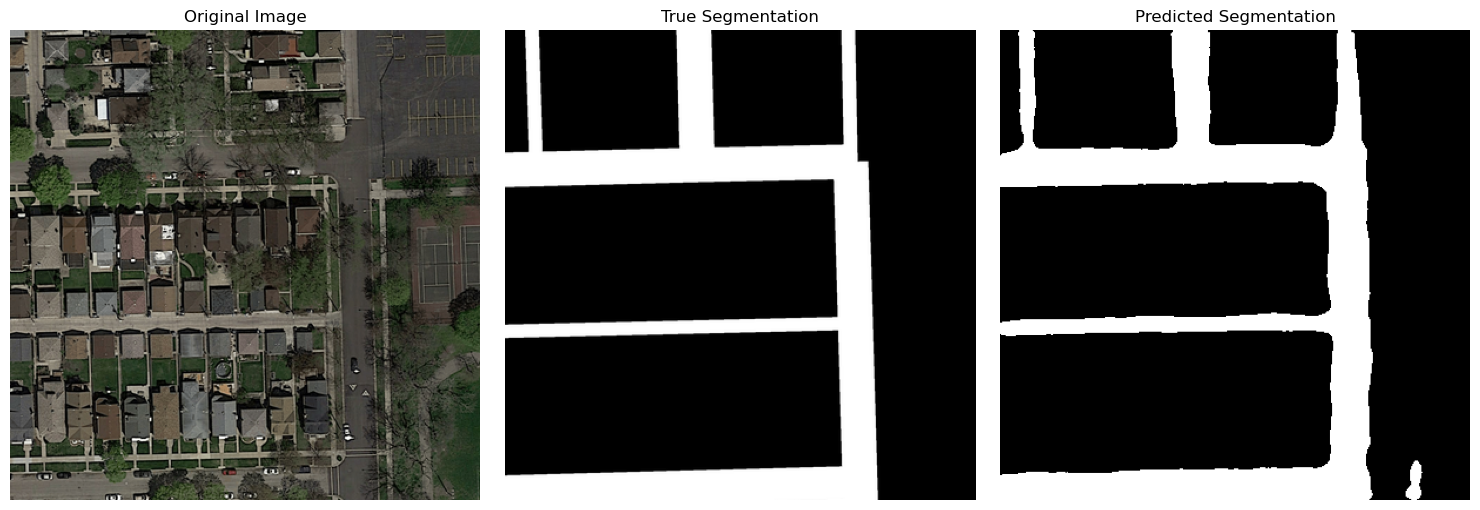

In [83]:
visualize_results(image_path, mask_path, prediction_normalized)

## Simple morphology closing for post-processing of the mask for better visualization

In [84]:
import cv2
#Step 1: Closing Morphology
binary_mask = (prediction_normalized * 255).astype(np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))
mask_cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)


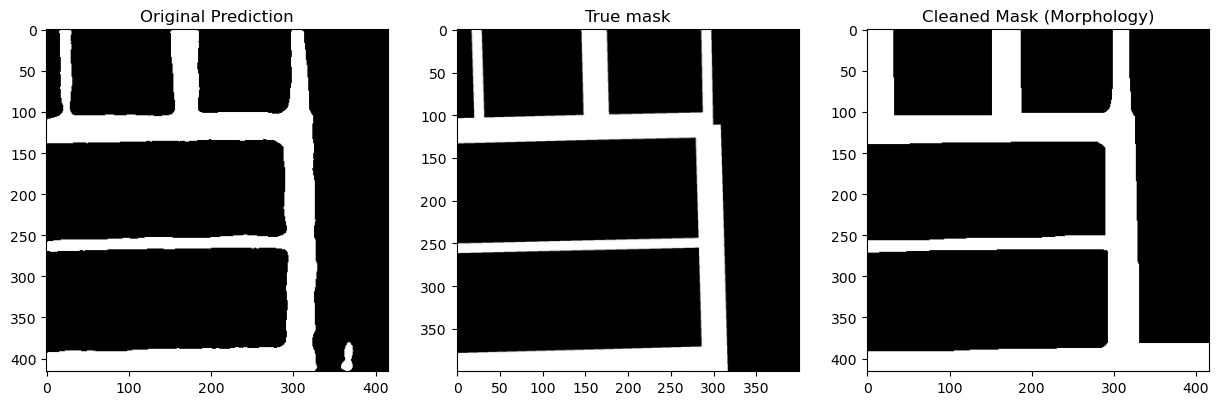

In [85]:
# Visualización
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Prediction")
plt.imshow(prediction_normalized, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("True mask")
plt.imshow(Image.open(mask_path), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Cleaned Mask (Morphology)")
plt.imshow(mask_cleaned, cmap="gray")

plt.show()